# Spaceship titanic Model

In [243]:
import numpy as np
import pandas as pd

## 1. Load data

In [244]:
data = pd.read_csv('datasets/spaceship-titanic/train.csv')
data.shape

(8693, 14)

## 2. Functions definition

In [245]:
def clean_data(data):
  df = data.drop(['Name'], axis=1)
  df = df.dropna()
  df = df.convert_dtypes()
  df = df.reset_index()
  df = df.drop(['index'], axis=1)

  # --- VARIABLES ---
  columns = list(df.columns)

  # --- CONVERT BOOLEAN COLUMNS TO INT ---
  for col in columns:
    if str(df[col].dtype) == 'boolean':
      df[col] = df[col].astype(int)
  
  # --- DECOMPOSE COMPOSE COLUMNS (PassengerId, Cabin) ---
  new_df = pd.DataFrame()
  for col in columns:
    if col == 'PassengerId':
      group_ids = []
      numbers   = []
    
      tmp = list(df[col])

      for id in tmp:
        group, number = id.split("_")
        group_ids.append(int(group))
        numbers.append(int(number))

      new_df['Group']  = group_ids
      new_df['Number'] = numbers

    elif col == 'Cabin':
      decks = []
      nums  = []
      sides = []

      for place in list(df[col]):
        deck, num, side = place.split("/")
        decks.append(deck)
        nums.append(int(num))
        sides.append(side)
      new_df['Deck']  = decks
      new_df['Num']   = nums
      new_df['Side']  = sides
    
    else:
      new_df[col] = df[col]
  df = new_df

  # --- CONVERT STRING COLUMNS TO INT ---
  decks_map = {}
  decks     = list(df.Deck.unique())
  for i in range(len(decks)):
    decks_map[decks[i]] = i
    
  destinations = {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}
  home_planet  = {'Europa': 0, 'Earth': 1, 'Mars': 2}
  sides        = {'P': 0, 'S': 1}

  df.Destination = df.Destination.map(destinations)
  df.HomePlanet  = df.HomePlanet.map(home_planet)
  df.Side        = df.Side.map(sides)
  df.Deck        = df.Deck.map(decks_map)
  df             = df.convert_dtypes()

  return df

In [246]:
def univaraite_selection(df, n, verbose=False):
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import chi2

  features = len(list(df.columns))

  X = df.iloc[:,0:(features-1)]
  y = df.iloc[:,-1]
  y = y.astype('int')

  bestfeatures  = SelectKBest(score_func=chi2, k=10)
  fit           = bestfeatures.fit(X, y)
  dfscores      = pd.DataFrame(fit.scores_)
  dfcolumns     = pd.DataFrame(X.columns)
  featureScores = pd.concat([dfcolumns, dfscores], axis=1)
  featureScores.columns = ['Specs', 'Score']

  if verbose:
    display(featureScores)

    print(n, " best features")
    print("================")
    print(featureScores.nlargest(n, 'Score'))

  return list(featureScores.nlargest(n, 'Score')['Specs'])

In [247]:
def feature_importance(df, n, verbose=False):
  from sklearn.ensemble import ExtraTreesClassifier
  import matplotlib.pyplot as plt
  
  features = len(list(df.columns))

  X = df.iloc[:,0:(features-1)]
  y = df.iloc[:,-1]
  y = y.astype('int')

  model = ExtraTreesClassifier()
  model.fit(X, y)

  feat_importances = pd.Series(model.feature_importances_, index=X.columns)

  if verbose:
    feat_importances.nlargest(n).plot(kind='barh')
    plt.show()

  return list(feat_importances.nlargest(n).index)

## 3. Clean data and select features

In [248]:
df       = clean_data(data)
features = feature_importance(df, 3)
dataset  = df[features + ['Transported']]

## 4. Split data into (x_train, y_train) and (x_test, y_test) and normalization

In [249]:
data_train = dataset.sample(frac=0.7, axis=0)
data_test  = dataset.drop(data_train.index)

x_train    = data_train.drop('Transported', axis=1)
y_train    = data_train['Transported']
x_test     = data_test.drop('Transported', axis=1)
y_test     = data_test['Transported']


mean    = x_train.mean()
std     = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train = np.array(x_train).astype(float)
y_train = np.array(y_train).reshape(-1, 1).astype(float)
x_test  = np.array(x_test).astype(float)
y_test  = np.array(y_test).reshape(-1, 1).astype(float)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (4735, 3)
y_train shape:  (4735, 1)
x_test shape:  (2029, 3)
y_test shape:  (2029, 1)


## 5. Build the model

In [250]:
from uzapy.architecture.dnn import DNN


def build_model(input_size):
  model = DNN(input_size)

  model.add(50, activation='sigmoid')
  model.add(20, activation='sigmoid')
  model.add(10, activation='sigmoid')
  model.add(1, activation='sigmoid')
  
  model.compile('binary_crossentropy', 'adam', ['accuracy'])

  return model

model = build_model(x_train.shape[1])

## 6. Train the model

100%|██████████| 60/60 [00:06<00:00,  8.58it/s]


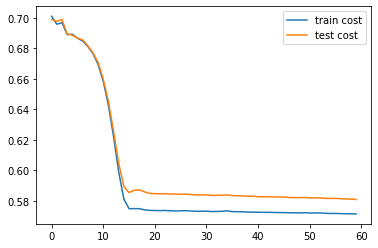

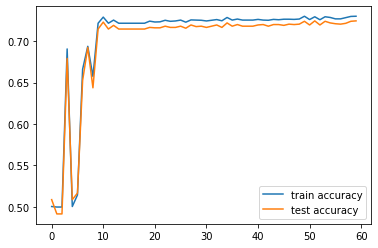

train accuracy:  0.7301
test  accuracy :  0.72449


In [251]:
model.train((x_train.T, y_train.T), (x_test.T, y_test.T), lr=0.001, batch_size=600, shuffle=True, epoch=60, verbose=False)
model.plot_history('cost', lloc='up')
model.plot_history('accuracy', lloc='down')
model.performance()

## 7. Load and clean validation data

In [252]:
val_data = pd.read_csv('datasets/spaceship-titanic/test.csv')
for col in list(val_data.columns):
  val_data[col] = val_data[col].fillna(val_data[col].mode()[0])
val_df = clean_data(val_data)

In [253]:
val_dataset = val_df[features]

In [254]:
X = np.array(val_dataset).astype(float)
X = (X - X.mean()) / X.std()

In [255]:
predictions = model.predict(X.T)

In [256]:
results = {
  'PassengerId': [], 
  'Transported': []
}
ids = list(val_data['PassengerId'])
for idx in range(len(ids)):
  y_pred = False if predictions[0][idx] < 0.5 else True
  results['PassengerId'].append(ids[idx])
  results['Transported'].append(y_pred)

tmp = pd.DataFrame.from_dict(results)

In [ ]:
tmp.to_csv('space_titanic_predictions.csv', index=False)